In [1]:
import scipy.io as scio
import math
import numpy as np
import matplotlib.pyplot as plt

dataMat = scio.loadmat('./dataset/1_data.mat')
x = dataMat['x']
t = dataMat['t']

In [6]:
M = 3

def phi(x, m, trans=1):
    X = []
    for i in range(m):
        # X += [sigmoid_basis(x,i, m)]
        X.append(sigmoid_basis(x,i, m))
    if trans:
        return np.array(X).reshape(-1, m)
    else:
        return np.array(X)

def sigmoid_basis(x, j, m, sigma=0.1):
    muj = (2*j)/ m
    a = (x - muj)/ sigma
    return 1/ (1 + np.exp(-a))

def predictive_dist(x, M, mN, SN, beta=1):
    phiX = phi(x, M, 0).T
    mean = phiX.dot(mN)
    covX = 1/beta + np.sum(phiX.dot(SN).dot(phiX.T), axis=1)
    std = np.sqrt(covX)
    return mean, std

def predict(w, x):
    return w.dot(x.T)

def gaussian_pdf(x, mean, sd):
    y = 1 / (2 * np.pi) * 1 / np.sqrt(np.linalg.det(sd)) * np.exp( -0.5 * ((x - mean).T.dot(np.linalg.inv(sd))).dot((x - mean)))
    return y

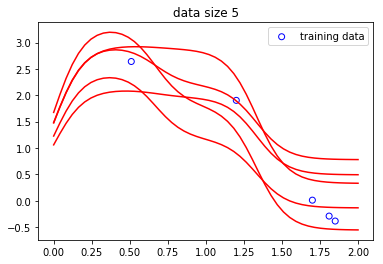

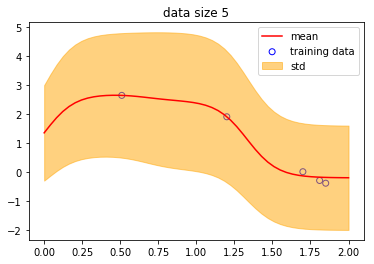

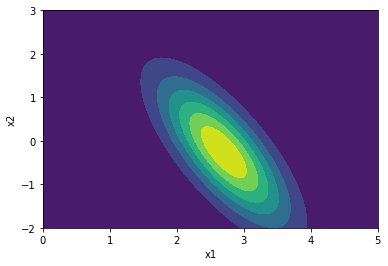

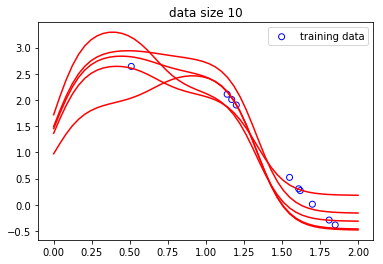

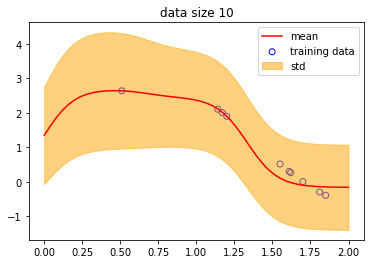

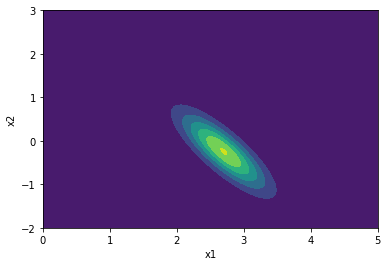

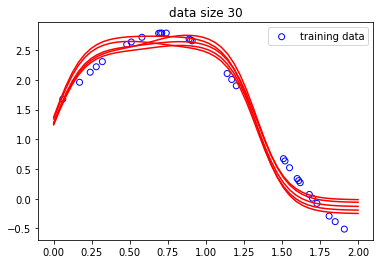

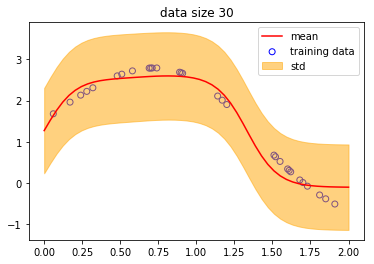

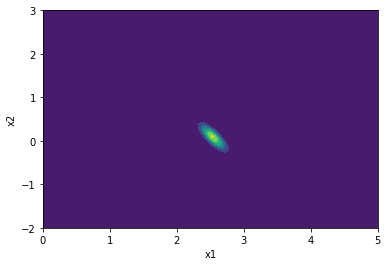

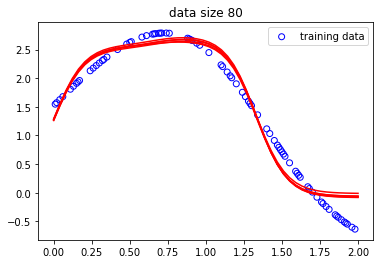

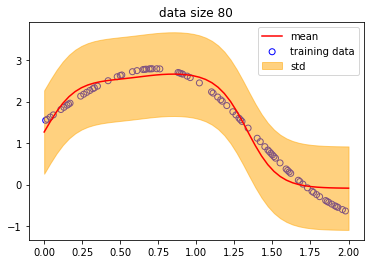

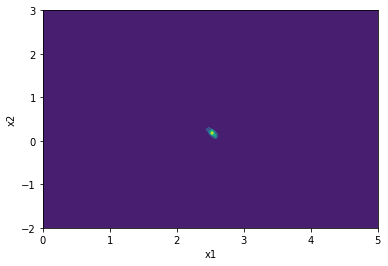

In [7]:
s0_inv = (10**-6) * np.identity(M) #S0
m0 = 0
beta = 1
MNs = []
SNs = []
data_len = [5,10,30,80]

# 大PHI矩陣(裡面有許多小phi)
PHI =  phi(x[0], M)
sn_inv = s0_inv + beta*PHI.T.dot(PHI)
sn = np.linalg.inv(sn_inv)
mn = sn.dot(beta*np.dot(PHI.T, t[0]))
# 每次多拿到一筆資料來更新M, S
for i in range(1, x.shape[0]):    
    # 存特定data筆數的mean跟std
    if i in data_len:
        MNs.append(mn)
        SNs.append(sn)
        # 第一種圖(Fig. 3.9)
        # plot data point
        plt.figure()
        plt.scatter(x[:i],t[:i], facecolor="none", edgecolor="b", label="training data")
        plt.legend()
        # sample five curve
        w_sampled = np.random.multivariate_normal(mn, sn, size=5)  # same as scipy multivariate_normal
        # sortX = np.array(sorted(x))
        sortX = np.linspace(0, 2, 50)
        pred = predict(w_sampled, phi(sortX, M, 0).T)
        # plot five curve that we just sampled
        for j in range(5):
            plt.title('data size %d' % i)
            plt.plot(sortX, pred[j], '-r')
            
        # clear the plot 
        plt.figure()
        # 2.第二種圖(Fig. 3.8)predictive distribution
        mean, std = predictive_dist(sortX, M, mn, sn)
        plt.title('data size %d' % i)
        plt.scatter(x[:i],t[:i], facecolor="none", edgecolor="b", label="training data")
        plt.plot(sortX, mean, 'r', label='mean')
        plt.fill_between(sortX.reshape(len(sortX)), mean-std, mean+std, alpha=0.5, color='orange', label='std')
        plt.legend()
        
        # 3. Fig. 3.7
        plt.figure()
        w0, w1 = np.meshgrid(np.linspace(0, 5, 100), np.linspace(-2, 3, 100))
        w_combined = np.array([w0, w1]).transpose(1, 2, 0)
        N_density = np.empty((100, 100))
        for f in range(N_density.shape[0]):
            for g in range(N_density.shape[1]):
                # select weight
                N_density[f, g] = gaussian_pdf(w_combined[f, g], mn_old[:2], np.linalg.inv(sn_inv_old)[:2, :2])
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.contourf(w0[0], w1[:, 0], N_density)
        
    # update M, S        
    PHI = np.vstack((PHI, phi(x[i], M)))
    mn_old = mn
    sn_inv_old = sn_inv
    sn_inv = sn_inv + beta*PHI.T.dot(PHI) # 計算Sn，且beta = 1
    sn = np.linalg.inv(sn_inv)
    # sn_inv跟mn要帶舊的
    mn = sn.dot(sn_inv_old.dot(mn)+beta*PHI.T.dot(t[:i+1]).reshape(-1,))

In [77]:
phi(sortX, M, 0).T


array([[5.00000000e-01, 1.27101626e-03, 1.61959417e-06],
       [6.00647383e-01, 1.91045149e-03, 2.43595300e-06],
       [6.93456009e-01, 2.87065538e-03, 3.66379718e-06],
       [7.72852705e-01, 4.31137858e-03, 5.51053387e-06],
       [8.36532757e-01, 6.47047920e-03, 8.28811033e-06],
       [8.85016365e-01, 9.70030453e-03, 1.24657027e-05],
       [9.20486798e-01, 1.45187802e-02, 1.87489559e-05],
       [9.45686734e-01, 2.16783633e-02, 2.81991513e-05],
       [9.63219238e-01, 3.22529714e-02, 4.24124068e-05],
       [9.75240368e-01, 4.77341453e-02, 6.37891314e-05],
       [9.83400317e-01, 7.01078387e-02, 9.59391306e-05],
       [9.88901622e-01, 1.01846817e-01, 1.44290531e-04],
       [9.92593470e-01, 1.45703140e-01, 2.17004780e-04],
       [9.95063365e-01, 2.04151867e-01, 3.26350928e-04],
       [9.96712339e-01, 2.78406245e-01, 4.90768265e-04],
       [9.97811720e-01, 3.67206987e-01, 7.37958783e-04],
       [9.98544010e-01, 4.66038766e-01, 1.10951619e-03],
       [9.99031483e-01, 5.67610